<a href="https://colab.research.google.com/github/egg528/Study_ML_sentimentClassifier/blob/main/LSTM_sentimentClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML_sentimentClassifier

## - LSTM

# 감성 분석을 위한 Data 전처리

## (1) 환경 설정

In [1]:
%%bash
apt-get update
apt-get install g++ openjdk-8-jdk python-dev python3-dev
pip3 install JPype1
pip3 install konlpy

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu 

In [2]:
%env JAVA_HOME "/usr/lib/jvm/java-8-openjdk-amd64"

env: JAVA_HOME="/usr/lib/jvm/java-8-openjdk-amd64"


In [3]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import re
import urllib.request
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext.legacy import data
from torchtext.legacy import datasets
import torch.optim as optim

from sklearn.model_selection import train_test_split

from konlpy.tag import Okt

In [4]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("cpu와 cuda 중 다음 기기로 학습함:", DEVICE)

cpu와 cuda 중 다음 기기로 학습함: cuda


## (2) 네이버 영화 리뷰 데이터 전처리

In [5]:
# https://github.com/e9t/nsmc/ <- Naver sentiment movie corpus v1.0
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7f37c0d8e090>)

In [6]:
train_data = pd.read_table('ratings_train.txt')
train_data = train_data.drop(columns=['id'])

print("훈련 데이터 개수: " + str(len(train_data)))
train_data[:5]


훈련 데이터 개수: 150000


,document,label
0,아 더빙.. 진짜 짜증나네요 목소리,0
1,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,너무재밓었다그래서보는것을추천한다,0
3,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [7]:
test_data = pd.read_table('ratings_test.txt')
test_data = test_data.drop(columns=['id'])
print("테스트 데이터 개수: " + str(len(test_data)))
test_data[:5]


테스트 데이터 개수: 50000


,document,label
0,굳 ㅋ,1
1,GDNTOPCLASSINTHECLUB,0
2,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [8]:
# train_data 중복 확인
len(train_data['document'].unique()), len(train_data['label'].unique())

(146183, 2)

In [9]:
# test_data 중복 확인
len(test_data['document'].unique()), len(test_data['label'].unique())

(49158, 2)

In [10]:
#중복 제거
train_data.drop_duplicates(subset=['document'], inplace=True)
test_data.drop_duplicates(subset=['document'], inplace=True)

print('총 샘플의 수 :',len(train_data))
print('총 샘플의 수 :',len(test_data))

총 샘플의 수 : 146183
총 샘플의 수 : 49158


In [11]:
# null값 제거
train_data = train_data.dropna(how = 'any')
test_data = test_data.dropna(how = 'any')

print('총 샘플의 수 :',len(train_data))
print('총 샘플의 수 :',len(test_data))

총 샘플의 수 : 146182
총 샘플의 수 : 49157


In [12]:
# 한글과 공백만 남기기
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


# 공백만 남은 문장 ""로 변경
train_data['document'] = train_data['document'].str.replace('^ +', "")
test_data['document'] = test_data['document'].str.replace('^ +', "")

# ""만 남은 문장 null로 변경
train_data['document'].replace('', np.nan, inplace=True)
test_data['document'].replace('', np.nan, inplace=True)

# null값 제거
train_data = train_data.dropna(how = 'any')
test_data = test_data.dropna(how = 'any')

print('총 샘플의 수 :',len(train_data))
print('총 샘플의 수 :',len(test_data))

총 샘플의 수 : 145393
총 샘플의 수 : 48852


In [13]:
train_data, valid_data = train_test_split(train_data, test_size=0.3, random_state=32)

print('훈련 데이터 총 샘플의 수 :',len(train_data))
print('검증 데이터 총 샘플의 수 :',len(valid_data))
print('테스트 데이터 총 샘플의 수 :',len(test_data))

훈련 데이터 총 샘플의 수 : 101775
검증 데이터 총 샘플의 수 : 43618
테스트 데이터 총 샘플의 수 : 48852


## (3) 데이터 확인

   label  count
0      0  51047
1      1  50728


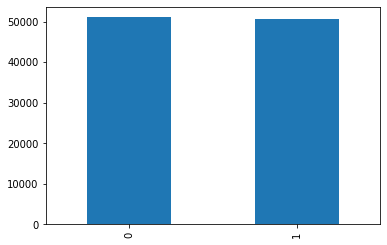

In [14]:
# 훈련 데이터 분포
print(train_data.groupby('label').size().reset_index(name = 'count'))
train_data['label'].value_counts().plot(kind = 'bar')

   label  count
0      0  21996
1      1  21622


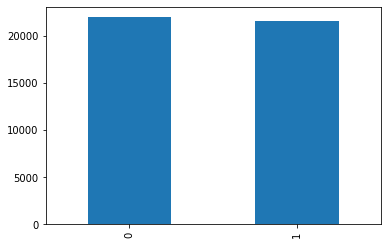

In [15]:
# 검증 데이터 분포
print(valid_data.groupby('label').size().reset_index(name = 'count'))
valid_data['label'].value_counts().plot(kind = 'bar')

   label  count
0      0  24332
1      1  24520


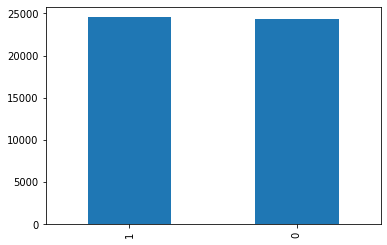

In [16]:
# 테스트 데이터 분포
print(test_data.groupby('label').size().reset_index(name = 'count'))
test_data['label'].value_counts().plot(kind = 'bar')

## (4) 문장 최대 길이 & 단어 빈도수(단어 집합)


In [17]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
tokenizer = Okt()

In [18]:
X_train = []
for sentence in train_data['document']:
    temp_X = tokenizer.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 11.007998034880865


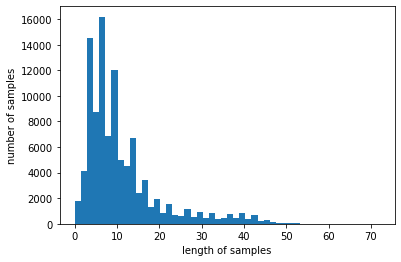

In [19]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [20]:
# 문장 길이가 'max_len'이하인 문장 비율 함수
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [21]:
# 90% 이상 커버(단어 제거 x)할 수 있는 max_len 찾기
below_threshold_len(30, X_train)
below_threshold_len(25, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.00835175632523
전체 샘플 중 길이가 25 이하인 샘플의 비율: 91.47727830999754


In [22]:
# 전체 단어 수를 구하기 위한 torchtext.Field 생성
Vocab = data.Field(use_vocab=True)
Vocab.build_vocab(X_train)

print('훈련 데이터 총 단어 개수: %s' %len(Vocab.vocab))

훈련 데이터 총 단어 개수: 37425


In [23]:
# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
# most_common() ==> collection.Counters를 튜플을 원소로 하는 리스트로 변환
def analysisVocabFreq(threshold, total_cnt, rare_cnt, total_freq, rare_freq):
  for key, value in Vocab.vocab.freqs.most_common():
      total_freq = total_freq + value

      # 단어의 등장 빈도수가 threshold보다 작으면
      if(value < threshold):
          rare_cnt = rare_cnt + 1
          rare_freq = rare_freq + value
  print('희귀 단어 = 등장 빈도 %s 미만' %threshold)
  print('단어 집합(vocabulary)의 크기 :',total_cnt)
  print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
  print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
  print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)
  print()

In [24]:
analysisVocabFreq(1, len(Vocab.vocab), 0, 0, 0)
analysisVocabFreq(2, len(Vocab.vocab), 0, 0, 0)
analysisVocabFreq(3, len(Vocab.vocab), 0, 0, 0)
analysisVocabFreq(4, len(Vocab.vocab), 0, 0, 0)

# 무엇을 기준으로 희긔 단어의 등장 빈도 기준을 정해야 할까..
# 등장 빈도 기준을 1 => 2로 바꿨을 때 16000 증가했다.
# 등장 빈도 기준을 2 => 3으로 바꿨을 때 희긔 단어 수는 약 5000개 증가했다.
# 반면 빈도 기준을 3 => 4로 바꿨을 때 희긔 단어 수는 약 2000애 증가했다.
# 3 => 4로 갈 추세가 많이 완만해졌음으로 희긔 단어의 등장 빈도 기준은 3으로 선택

희귀 단어 = 등장 빈도 1 미만
단어 집합(vocabulary)의 크기 : 37425
등장 빈도가 0번 이하인 희귀 단어의 수: 0
단어 집합에서 희귀 단어의 비율: 0.0
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.0

희귀 단어 = 등장 빈도 2 미만
단어 집합(vocabulary)의 크기 : 37425
등장 빈도가 1번 이하인 희귀 단어의 수: 16157
단어 집합에서 희귀 단어의 비율: 43.171676686706746
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.4421527769719702

희귀 단어 = 등장 빈도 3 미만
단어 집합(vocabulary)의 크기 : 37425
등장 빈도가 2번 이하인 희귀 단어의 수: 21156
단어 집합에서 희귀 단어의 비율: 56.52905811623247
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.3345612354831884

희귀 단어 = 등장 빈도 4 미만
단어 집합(vocabulary)의 크기 : 37425
등장 빈도가 3번 이하인 희귀 단어의 수: 23918
단어 집합에서 희귀 단어의 비율: 63.909151636606545
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.0741588037192313



## (5) Torchtext를 이용한 자연어 전처리 및 Iterator 생성


In [25]:
TEXT = data.Field(sequential=True, use_vocab=True, tokenize=tokenizer.morphs, stop_words=['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다'], lower=False, batch_first=True, fix_length=25)
LABEL = data.LabelField(dtype = torch.float)

In [26]:
def convert_dataset(input_data, text, label):
    list_of_example = [data.Example.fromlist(row.tolist(), fields=[('text', text), ('label', label)])  for _, row in input_data.iterrows()]
    dataset = data.Dataset(examples=list_of_example, fields=[('text', text), ('label', label)])
    return dataset

In [27]:
train_dataset = convert_dataset(train_data,TEXT, LABEL)
valid_dataset = convert_dataset(valid_data, TEXT, LABEL)

In [28]:
TEXT.build_vocab(X_train,min_freq = 4)
LABEL.build_vocab([0, 1])

In [29]:
print(TEXT.vocab.stoi)
print(LABEL.vocab.stoi)

defaultdict(<bound method Vocab._default_unk_index of <torchtext.legacy.vocab.Vocab object at 0x7f37794bde90>>, {'<unk>': 0, '<pad>': 1, '영화': 2, '보다': 3, '을': 4, '없다': 5, '이다': 6, '있다': 7, '좋다': 8, '너무': 9, '다': 10, '정말': 11, '되다': 12, '재밌다': 13, '적': 14, '만': 15, '같다': 16, '진짜': 17, '아니다': 18, '않다': 19, '로': 20, '점': 21, '에서': 22, '만들다': 23, '것': 24, '나오다': 25, '연기': 26, '평점': 27, '내': 28, '최고': 29, '그': 30, '나': 31, '안': 32, '인': 33, '스토리': 34, '못': 35, '생각': 36, '왜': 37, '드라마': 38, '게': 39, '감동': 40, '사람': 41, '보고': 42, '이렇다': 43, '말': 44, '고': 45, '더': 46, '아깝다': 47, '배우': 48, 'ㅋㅋ': 49, '때': 50, '거': 51, '아': 52, '그냥': 53, '감독': 54, '요': 55, '재미있다': 56, '내용': 57, '재미': 58, '시간': 59, '까지': 60, '뭐': 61, '주다': 62, '중': 63, '자다': 64, '하고': 65, '지루하다': 66, '수': 67, '재미없다': 68, '쓰레기': 69, '네': 70, '가다': 71, '모르다': 72, '들다': 73, '그렇다': 74, '싶다': 75, '지': 76, '작품': 77, '사랑': 78, '알다': 79, '다시': 80, '하나': 81, '볼': 82, '마지막': 83, '저': 84, '이건': 85, '정도': 86, '완전': 87, 'ㅋ': 88, 'ㅠㅠ': 89, '처음

In [30]:
test_dataset = convert_dataset(test_data, TEXT, LABEL)

In [31]:
batch_size = 5
train_iter, valid_iter, test_iter = data.Iterator.splits((train_dataset, valid_dataset, test_dataset), batch_size=batch_size, sort=False, device=DEVICE)

In [32]:
print('훈련 데이터의 미니 배치 수 : {}'.format(len(train_iter)))
print('평가 데이터의 미니 배치 수 : {}'.format(len(valid_iter)))
print('테스트 데이터의 미니 배치 수 : {}'.format(len(test_iter)))

훈련 데이터의 미니 배치 수 : 20355
평가 데이터의 미니 배치 수 : 8724
테스트 데이터의 미니 배치 수 : 9771


# LSTM

In [33]:
class LSTM(nn.Module):
  # input_dim = 단어 사전 크기
  # hidden_dim = 은닉층
  # output_dim = 출력 값
  # embedding_dim = 임베딩 벡터 차원 
  def __init__(self, input_dim, hidden_dim, output_dim, embedding_dim, dropout):
    super().__init__()
    self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx=0)

    self.rnn = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, dropout=dropout)

    self.linear = nn.Linear(hidden_dim, output_dim)

    self.dropout = nn.Dropout(dropout)
  
  def forward(self, x):
    embed = self.dropout(self.embedding(x))
    output, _ = self.rnn(embed)
    output = self.linear(output[:, -1, :])
    return output
  
  def _init_state(self, batch_size=1):
    weight = next(self.parameters()).data
    return weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()

In [71]:

def binary_accuracy(prediction, target):
  '''
from https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/1%20-%20Simple%20Sentiment%20Analysis.ipynb
  '''
  # round predictions to the closest integer (0 or 1)
  rounded_preds = torch.round(torch.sigmoid(prediction))
  
  #convert into float for division
  correct = (rounded_preds == target).float()

  # rounded_preds = [ 1   0   0   1   1   1   0   1   1   1]
  # targets       = [ 1   0   1   1   1   1   0   1   1   0]
  # correct       = [1.0 1.0 0.0 1.0 1.0 1.0 1.0 1.0 1.0 0.0]
  acc = correct.sum() / len(correct)
  return acc

In [56]:
def train(model, train_iter):
  model.train()

  epoch_loss, epoch_acc = 0, 0
  for batch in train_iter:
    optimizer.zero_grad()
    x, y = batch.text.to(DEVICE), batch.label.to(DEVICE)
    y_hat = model(x).squeeze(1)

    loss = criterion(y_hat, y)
    acc = binary_accuracy(y_hat, y)

    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()
    epoch_acc += acc.item()

  return epoch_loss / len(train_iter), epoch_acc / len(train_iter)

In [44]:
def evaluate(model, valid_iter):
  model.eval()
  with torch.no_grad():
    eval_loss, eval_acc = 0, 0
    for batch in valid_iter:
      x,y = batch.text.to(DEVICE), batch.label.to(DEVICE)
      y_hat = model(x).squeeze(1)
      
      loss = criterion(y_hat, y)
      acc = binary_accuracy(y_hat, y)

      eval_loss += loss.item()
      eval_acc += acc.item()
      
  return eval_loss / len(valid_iter), eval_acc / len(valid_iter)

In [45]:
def inference(model, test_iter):
  model.eval()
  with torch.no_grad():
    test_loss, test_acc = 0, 0
    for batch in test_iter:
      x, y = batch.text.to(DEVICE), batch.label.to(DEVICE)
      y_hat = model(x).squeeze(1)

      loss = criterion(y_hat, y)
      acc = binary_accuracy(y_hat, y)
      
      test_loss += loss.item()
      test_acc += acc.item()

  return test_loss / len(test_iter), test_acc / len(test_iter)

In [46]:
model = LSTM(len(TEXT.vocab), 128, len(LABEL.vocab)-1, 300, 0.2)
model.to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()
criterion.to(DEVICE)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


BCEWithLogitsLoss()

In [47]:
best_val_loss = float('inf')
for _epoch in range(1,6): # 5 epoch
  train_loss, train_acc = train(model, train_iter)
  valid_loss, valid_acc = evaluate(model, valid_iter)
  print("[Epoch: %d] train loss : %5.2f | train accuracy : %5.2f" % (_epoch, train_loss, train_acc))
  print("[Epoch: %d] val loss : %5.2f | val accuracy : %5.2f" % (_epoch, valid_loss, valid_acc))

    # 검증 오차가 가장 적은 최적의 모델을 저장
  if valid_loss < best_val_loss:
    best_val_loss = valid_loss

[Epoch: 1] train loss :  0.52 | train accuracy :  0.73
[Epoch: 1] val loss :  0.45 | val accuracy :  0.78
[Epoch: 2] train loss :  0.42 | train accuracy :  0.80
[Epoch: 2] val loss :  0.44 | val accuracy :  0.79
[Epoch: 3] train loss :  0.39 | train accuracy :  0.82
[Epoch: 3] val loss :  0.44 | val accuracy :  0.80
[Epoch: 4] train loss :  0.36 | train accuracy :  0.84
[Epoch: 4] val loss :  0.45 | val accuracy :  0.80
[Epoch: 5] train loss :  0.35 | train accuracy :  0.84
[Epoch: 5] val loss :  0.45 | val accuracy :  0.80
